In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import kagglehub
from kagglehub import KaggleDatasetAdapter
from sympy import Symbol, IndexedBase, Function, Array, Lambda
from sympy.concrete.summations import Sum

# Load Dataset

The dataset used is from abhishek14398, procured from Kaggle. It is a simple 2 features dataset:
- Year of experience
- Salary

With salary being the target variable

In [49]:
path = "dataset/salary"

df = kagglehub.dataset_load(
    KaggleDatasetAdapter.PANDAS,
    "abhishek14398/salary-dataset-simple-linear-regression",
    "Salary_dataset.csv",
    pandas_kwargs={"index_col": 0},
)

print("DataFrame:\n", df)

DataFrame:
     YearsExperience    Salary
0               1.2   39344.0
1               1.4   46206.0
2               1.6   37732.0
3               2.1   43526.0
4               2.3   39892.0
5               3.0   56643.0
6               3.1   60151.0
7               3.3   54446.0
8               3.3   64446.0
9               3.8   57190.0
10              4.0   63219.0
11              4.1   55795.0
12              4.1   56958.0
13              4.2   57082.0
14              4.6   61112.0
15              5.0   67939.0
16              5.2   66030.0
17              5.4   83089.0
18              6.0   81364.0
19              6.1   93941.0
20              6.9   91739.0
21              7.2   98274.0
22              8.0  101303.0
23              8.3  113813.0
24              8.8  109432.0
25              9.1  105583.0
26              9.6  116970.0
27              9.7  112636.0
28             10.4  122392.0
29             10.6  121873.0


# Separate X and Y

In [50]:
y = df.pop("Salary")

# Visualise dataset

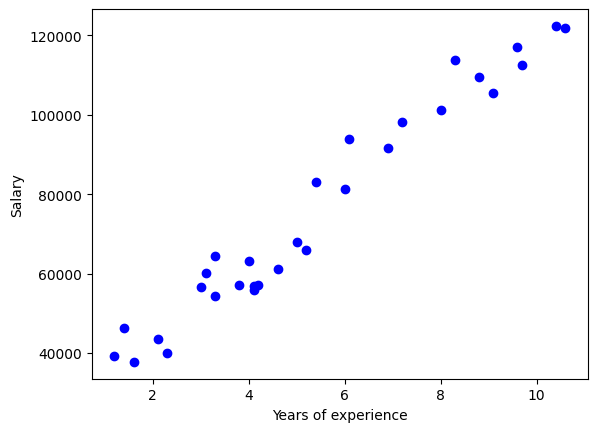

In [51]:
plt.plot(df['YearsExperience'], y, 'bo')
plt.xlabel("Years of experience")
plt.ylabel("Salary")
plt.show()

# Linear Regression With Scikit-Learn

It's important to benchmark the performance of the linear regression from scratch vs with a library.

In [52]:
from sklearn.linear_model import LinearRegression

sklearn_linear_regression = LinearRegression().fit(df, y)

sklearn_y_pred = sklearn_linear_regression.predict(df)

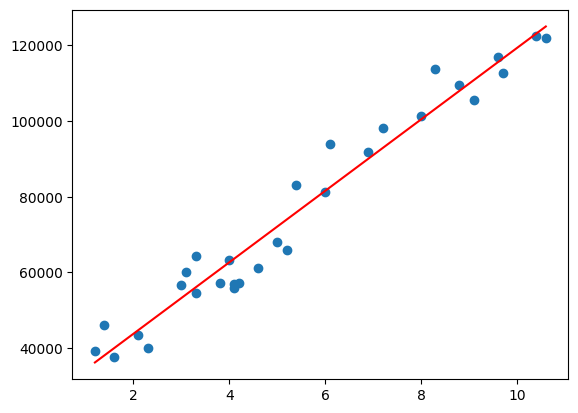

MSE for sklearn's linear regression: 31,270,951.72


In [53]:
plt.scatter(df["YearsExperience"], y)
plt.plot(df["YearsExperience"], sklearn_y_pred, "r")
plt.show()

sklearn_mse_score = mean_squared_error(sklearn_y_pred, y)

print(f"MSE for sklearn's linear regression: {sklearn_mse_score:,.2f}")

# From Scratch with Gradient Descent and MSE

## MSE Loss Function
The following loss equation is used 
$$(H(x) - y)^2$$
with:
- $H()$: The hypothesis function (regression equation) or the predicted output
- $x$: Features
- $y$: True value

The resulting cost function will be
$$
    \displaystyle\sum_{i=0}^N (H(x_i) - y_i)^2
$$
with:
- $N$: Number of training samples minus 1

In [54]:
# Loss function
class MSELoss(Function):
    def __init__(self, hypothesis: Lambda):
        super().__init__()
        features = IndexedBase("x")
        y_true = Symbol("y_true")

        self.equation = (hypothesis(features) - y_true)**2    

## Linear Regression Model

Linear regression uses the following equation
$$
    \theta_0 + \displaystyle\sum_{j=1}^M \theta_j x_j 
$$

with:
- $\theta_0$: Bias weight
- $\theta$: Parameters weight
- $M$: Number of features 
- $x$: Features

To further simplify the equation, it is simplified to
$$
    \displaystyle\sum_{j=0}^M \theta_j x_j 
$$
where $x_0 = 1$

In [55]:
class LinearRegressionModel():
    def __init__(self, num_features):
        super().__init__()

        # Defined Symbols and IndexedBase to be used on the Linear Regression Equation
        self.parameters_symbol = IndexedBase("Theta")
        features = IndexedBase("x")
        iteration = Symbol("i")

        # Initialise model's parameters
        self.parameters = []
        for i in range(num_features+1):
            self.parameters.append(1.0)

        # Build the linear regression equation
        equation = Sum((
            self.parameters_symbol[iteration]*features[iteration]), 
            (iteration, 0, num_features)
            ).doit()
        self.equation = Lambda((features), equation.subs("x", features))

    def predict(self, features):
        '''
            features (pandas.Series): Series a length of self.parameters - 1. 
        '''
        # Preprocess input features to include series of 1s at the first row.
        # This is used to calculate the intercept 
        one = pd.Series(1.0)
        features = pd.concat([one, features])
        features = features.tolist()

        # Substitute the parameters and feature values
        result = self.equation(Array(features))
        result = result.subs("Theta", Array(self.parameters))

        return result

## Evaluation Function

This function evaluates the model by using scikit-learn's MSE function. It also visualises the model's prediction 

In [56]:
def eval_model(model, title):
    y_pred = []

    # Get predictions for all of the training rows
    for i in range(len(df)):
        row = df.iloc[i]
        y_pred.append(model.predict(row))
    mse_score = mean_squared_error(y_pred, y)

    plt.title(title)
    plt.scatter(df["YearsExperience"], y)
    plt.plot(df["YearsExperience"], y_pred, "r")
    plt.show()
    print(f"Mean squared error: {mse_score:,.2f}")

    return mse_score

## Gradient Descent

The gradient descent equation is as follows:
$$
    \displaystyle\sum_{j=0}^M \theta_j := \theta_j - \frac{\partial J(\theta_j)}{\partial\theta_j}
$$

with:
- $M$: Number of parameters
- $\theta$: Parameters
- $J()$: Cost function

In [ ]:
def gradient_descent(model, loss_fn, LR_RATE=1e-3):
    for param_it in range(len(model.parameters)):
        differentiated_loss_value = 0
        # Differentiate the loss function and calculate the loss over all of the training samples
        for i in range(len(df)):
            # Preprocess the row to include an extra feature at index 0. This feature is used to calculate the intercept of the model
            train_row = df.iloc[i]
            one = pd.Series(1.0)
            train_row = pd.concat([one, train_row]).tolist()
            y_row = y[i].item()
            

            loss_fn_differentiated = loss_fn.equation.diff(IndexedBase("Theta")[param_it])
            differentiated_loss_value += loss_fn_differentiated.subs([("Theta", Array(model.parameters)), ("x", Array(train_row)), ("y_true", y_row)])

        differentiated_loss_value /= 2

        # Adjust per the learning rate
        differentiated_loss_value *= LR_RATE
        # Calculate the new parameter weight and assign it
        model.parameters[param_it] = model.parameters[param_it] - differentiated_loss_value

        return differentiated_loss_value

# Training Loop

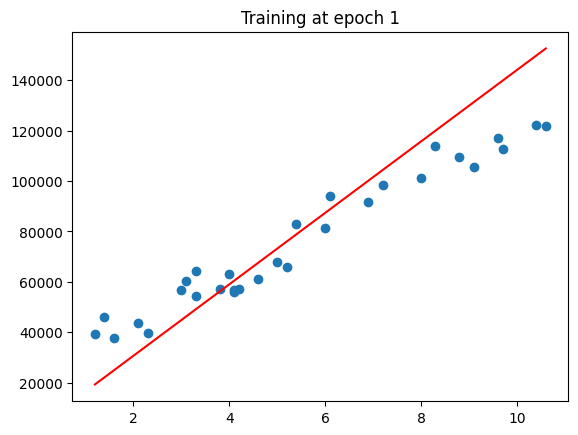

Mean squared error: 214,636,721.44


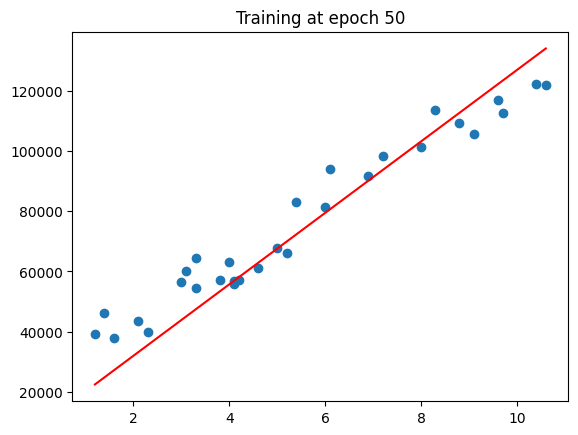

Mean squared error: 89,827,261.68


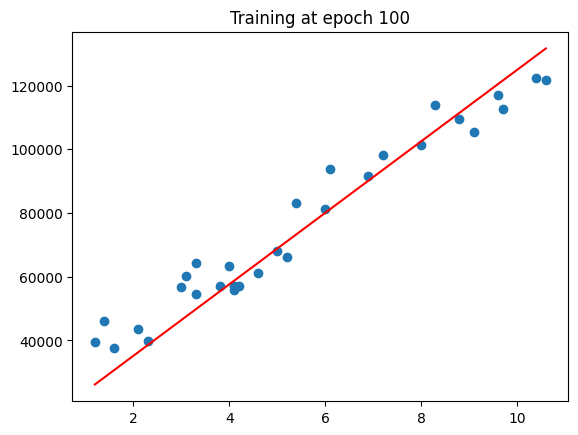

Mean squared error: 62,356,899.34


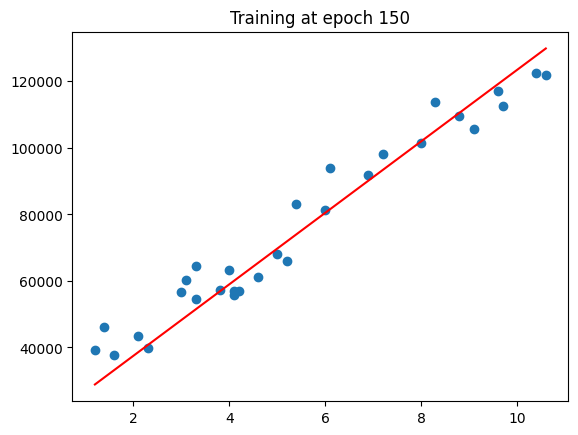

Mean squared error: 47,773,633.32


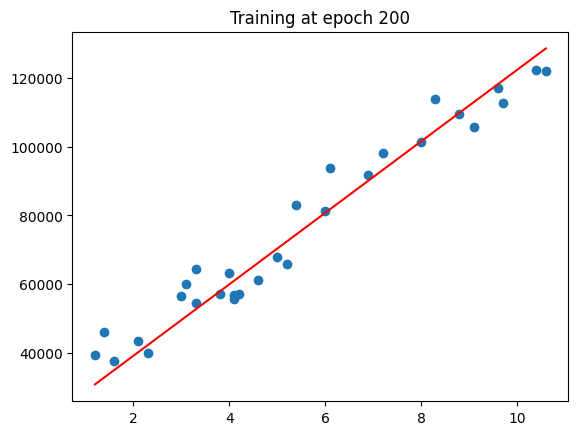

Mean squared error: 40,031,775.21


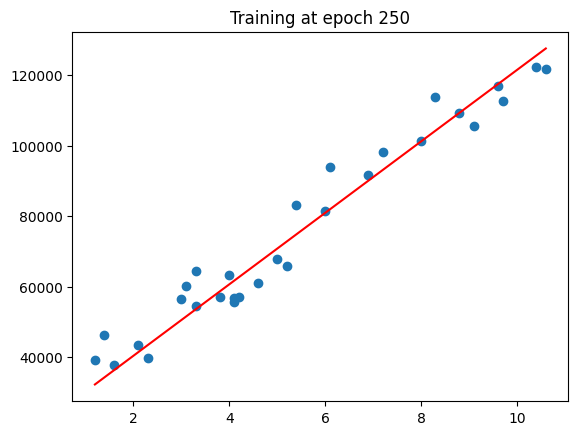

Mean squared error: 35,921,833.93


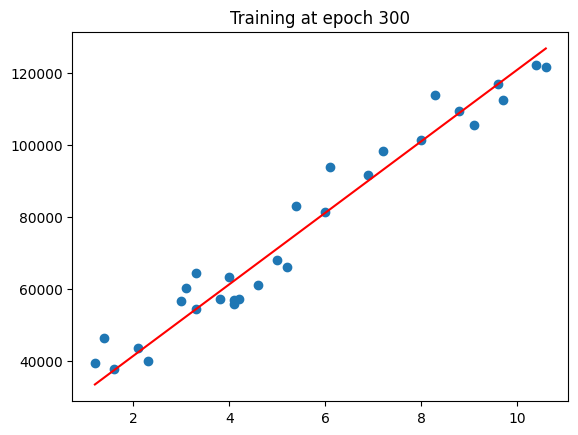

Mean squared error: 33,739,978.22


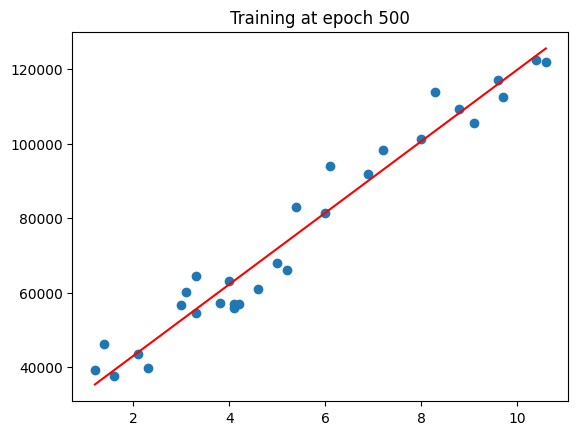

Mean squared error: 31,467,056.15


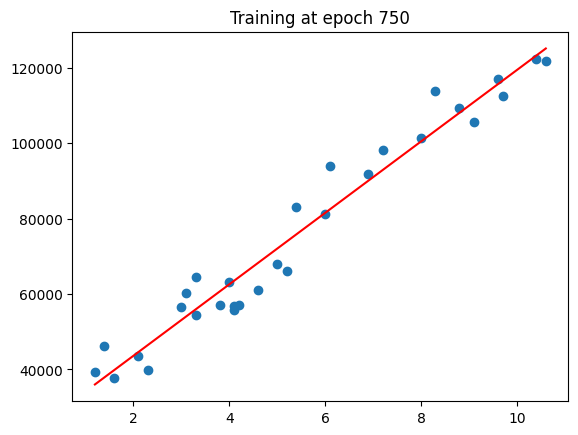

Mean squared error: 31,279,220.46


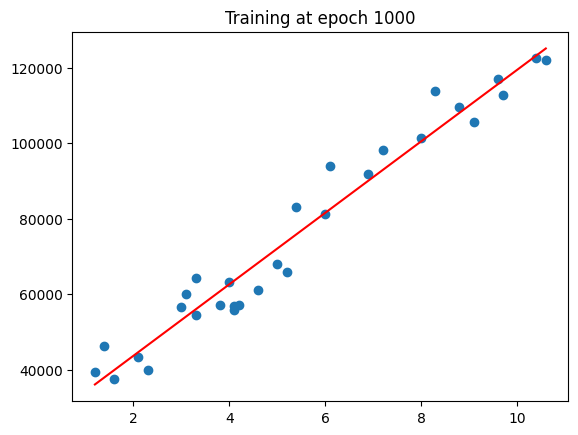

Mean squared error: 31,271,300.37


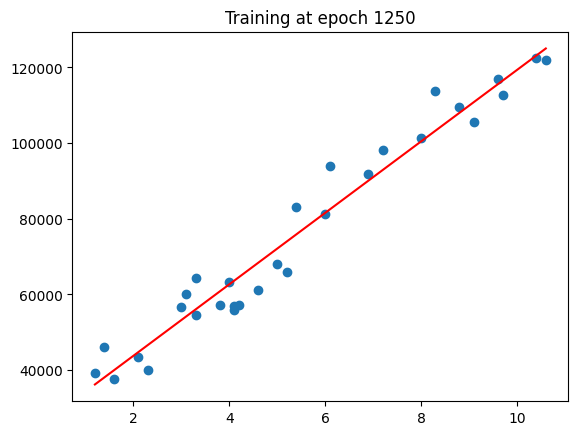

Mean squared error: 31,270,966.42


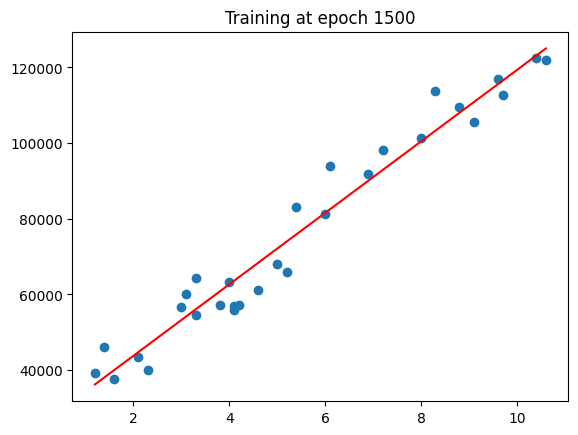

Mean squared error: 31,270,952.34


In [ ]:
# Training parameters
LR_RATE = 1e-3

NUM_FEATURES = len(df.columns)
model = LinearRegressionModel(NUM_FEATURES)
loss_fn = MSELoss(model.equation)
epoch = 0

# Train number amount of epochs
while True:
    # Per epoch, do gradient descent step on each of the model's parameters
    differentiated_loss_value = gradient_descent(model, loss_fn, LR_RATE)

    epoch += 1
    if epoch == 1 or (epoch <= 300 and epoch % 50 == 0) or (epoch > 300 and epoch % 250 == 0):
        mse_score = eval_model(model, f"Training at epoch {epoch}")

    
    if abs(differentiated_loss_value) <= LR_RATE:
        break



In [61]:
print(f"Scikit-learn's model achieves MSE of {sklearn_mse_score:,.2f}\nBuilding from scratch approach achieves MSE of {mse_score:,.2f}")

Scikit-learn's model achieves MSE of 31,270,951.72
Building from scratch approach achieves MSE of 31,270,952.34
